Učitavanje skupova podataka...

        id              name screen_name  statuses_count  followers_count  \
0  3610511  Davide Dellacasa      braddd           20370             5470   
1  5656162    Simone Economo       eKoeS            3131              506   
2  5682702            tacone     tacone_            4024              264   
3  6067292          alesaura    alesstar           40586              640   
4  6015122            Angelo  PerDiletto            2016               62   

   friends_count  favourites_count  listed_count  \
0           2385               145            52   
1            381                 9            40   
2             87               323            16   
3            622              1118            32   
4             64                13             0   

                       created_at                                url  ...  \
0  Fri Apr 06 10:58:22 +0000 2007           http://braddd.tumblr.com  ...   
1  Mon Apr 30 15:08:42 +0000 2007     

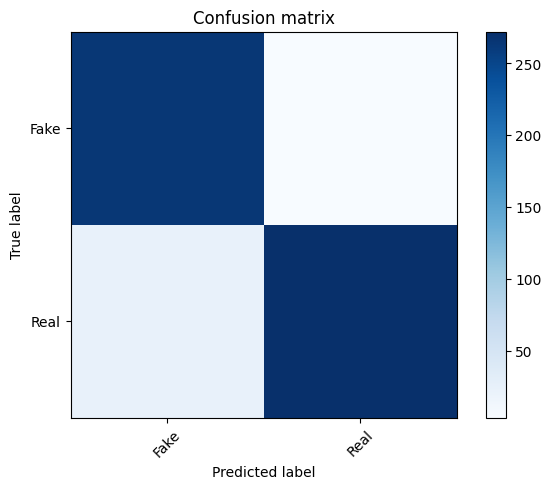

Normalizovana matrica konfuzije
[[0.98507463 0.01492537]
 [0.08108108 0.91891892]]


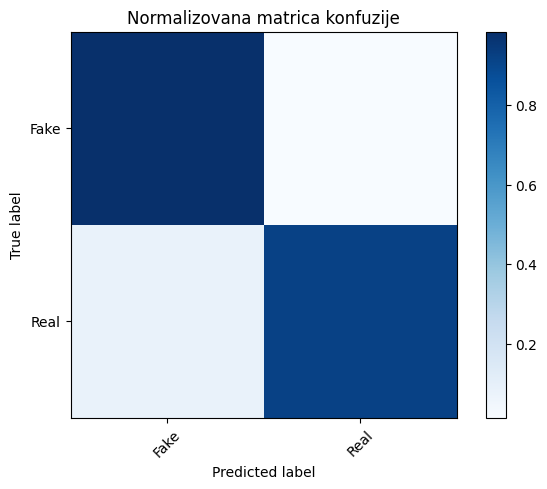

              precision    recall  f1-score   support

        Fake       0.92      0.99      0.95       268
        Real       0.99      0.92      0.95       296

    accuracy                           0.95       564
   macro avg       0.95      0.95      0.95       564
weighted avg       0.95      0.95      0.95       564



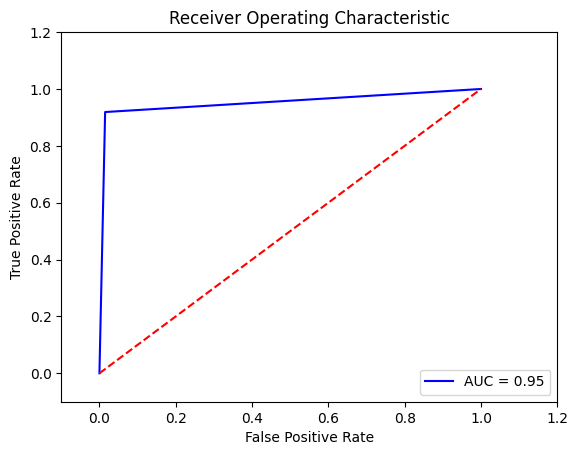

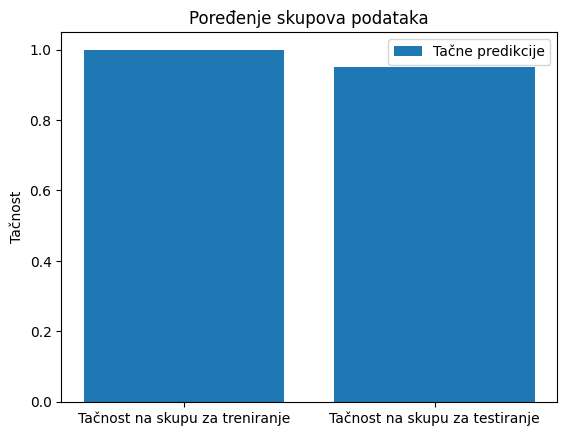

In [13]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Ucitavanje skupa podataka
def read_datasets():
    """ Ucitanje profile korisnika iz CSV fajlova """
    real_users = pd.read_csv("users.csv")
    fake_users = pd.read_csv("fusers.csv")
    # Kombinovanje stvarnih i lažnih korisnika
    x = pd.concat([real_users, fake_users])   
    y = len(fake_users) * [0] + len(real_users) * [1]
    return x, y

# Ekstrakcija karakteristika
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))
    lang_dict = {name: i for i, name in lang_list}
    x.loc[:, 'lang_code'] = x['lang'].map(lambda x: lang_dict[x]).astype(int)
    feature_columns_to_use = ['id', 'statuses_count', 'followers_count', 'friends_count', 'lang_code', 'favourites_count', 'listed_count']
    x = x.loc[:, feature_columns_to_use]
    return x

# Prikazivanje matrice konfuzije
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names = ['Fake', 'Real']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Prikazivanje ROC krive
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(y_test, y_pred)
    roc_auc = sklearn.metrics.auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Glavni deo programa
print("Učitavanje skupova podataka...\n")
x, y = read_datasets()
print(x.head())
print("Ekstrakcija karakteristika...\n")
x = extract_features(x)
print(x.columns)
print(x.describe())
print("Podela skupova podataka na trening i test skupove...\n")
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=44)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_train)
print(X_test)
print("Treniranje skupova podataka...\n")
clf = RandomForestClassifier(n_estimators=40, oob_score=True)
trained_model = clf.fit(X_train, y_train)
print("Najbolji klasifikator je: ", clf)

# Predikcija
y_pred = clf.predict(X_test)
print('Tačnost klasifikacije na skupu za treniranje: ', sklearn.metrics.accuracy_score(y_train, trained_model.predict(X_train)))
print('Tačnost klasifikacije na skupu za testiranje: ', sklearn.metrics.accuracy_score(y_test, y_pred))

# Matrica konfuzije
cm = confusion_matrix(y_test, y_pred)
print('Matrica konfuzije bez normalizacije')
print(cm)
plot_confusion_matrix(cm)
plt.show()

# Normalizovana matrica konfuzije
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalizovana matrica konfuzije')
print(cm_normalized)
plot_confusion_matrix(cm_normalized, title='Normalizovana matrica konfuzije')
plt.show()

# Izveštaj o klasifikaciji
print(sklearn.metrics.classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# ROC kriva
plot_roc_curve(y_test, y_pred)
plt.show()

# Uporedna tačnost
accuracy_model = ['Tačnost na skupu za treniranje', 'Tačnost na skupu za testiranje']
accuracy = [sklearn.metrics.accuracy_score(y_train, trained_model.predict(X_train)), sklearn.metrics.accuracy_score(y_test, y_pred)]

xpos = np.arange(len(accuracy_model))
plt.bar(xpos, accuracy, label="Tačne predikcije")
plt.xticks(xpos, accuracy_model)
plt.ylabel("Tačnost")
plt.title('Poređenje skupova podataka')
plt.legend()
plt.show()
